# Sea level trend bias diagnostic
finding the sea level trend bias during different period and the reason that causing the bias.

In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

Client Scheduler: inproc://128.196.236.68/12861/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 67.54 GB


In [2]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 131.859375 MB


# Model

In [3]:
#### possible input info from external text file
# constant setting
syear = 1993           
fyear = 2007

tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos']
Area_name = ['areacello_cu','areacello_cv','areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [4]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [ ]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo


In [6]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist[model][var].time.copy()
        year = ds_model_mlist[model][var]['time.year'].values
        month = ds_model_mlist[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist[model][var] = ds_model_mlist[model][var]-\
                                     (da_time*linear_mlist[model][var]['slope']+linear_mlist[model][var]['intercept'])

In [7]:
used_memory()

used 4316.019531 MB


# Observation

In [8]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011],[1993,2018,9]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty'],['adt']]

Obs_name = ['WESwind','CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]

obs = Obs_name[1]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [9]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [10]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
        # remove linear trend 
        obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

    obs_linear_mlist[obs] = obs_linear_list
    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read WESwind tx
read WESwind ty
read CMEMS adt


In [11]:
# detrend 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        da_time = ds_obs_mlist[obs][var].time.copy()
        year = ds_obs_mlist[obs][var]['time.year'].values
        month = ds_obs_mlist[obs][var]['time.month'].values
        da_time.values = year+month/12.
        ds_obs_mlist[obs][var] = ds_obs_mlist[obs][var]-\
                (da_time*obs_linear_mlist[obs][var]['slope']+obs_linear_mlist[obs][var]['intercept'])

In [12]:
used_memory()

used 5372.457031 MB


# Regridding

In [13]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [14]:
used_memory()

used 5417.699219 MB


In [15]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [16]:
import xesmf as xe

# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(season_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
model variable same as standard model variable
Overwrite existing file: CORE_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [17]:
# create regridder
for nobs,obs in enumerate(Obs_name):
    regridder_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        regridder = xe.Regridder(obs_season_mlist[obs][var], 
                                 da_model_standard, 
                                 'bilinear',
                                 filename='%s_%s2%s_%s.nc'%(obs,var,Model_standard,Variable_standard),
                                 periodic=True,
                                 reuse_weights=False)
        regridder_list['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[obs] = regridder_list

Overwrite existing file: WESwind_tx2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: WESwind_ty2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CMEMS_adt2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [18]:
varlist = list(linear_mlist['JRA']['zos'].keys())

regrid_regress_mlist = {}
#### regridding trend field 
for nmodel,model in enumerate(Model_name):
    regrid_regress_list = {}
    for nvar,var in enumerate(Model_varname):
        regrid_regress = xr.Dataset()
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
            regrid_regress_list[var] = linear_mlist[model][var]
        else:
            for ndavar,davar in enumerate(varlist):
                regrid_regress[davar] = \
                  regridder_mlist[model]['%s_%s2%s_%s'%(model,
                                                        var,
                                                        Model_standard,
                                                        Variable_standard)](linear_mlist[model][var][davar])
            regrid_regress_list[var] = regrid_regress
            regrid_regress_list[var]['x'] = da_model_standard.x.values
            regrid_regress_list[var]['y'] = da_model_standard.y.values
    regrid_regress_mlist[model] = regrid_regress_list
                    

model variable same as standard model variable


In [19]:
varlist = list(linear_mlist['JRA']['zos'].keys())

obs_regrid_regress_mlist = {}
#### regridding trend field 
for nobs,obs in enumerate(Obs_name):
    obs_regrid_regress_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_regrid_regress = xr.Dataset()
        for ndavar,davar in enumerate(varlist):
            obs_regrid_regress[davar] = \
              regridder_mlist[obs]['%s_%s2%s_%s'%(obs,
                                                  var,
                                                  Model_standard,
                                                  Variable_standard)](obs_linear_mlist[obs][var][davar])
        obs_regrid_regress_list[var] = obs_regrid_regress
        obs_regrid_regress_list[var]['x'] = da_model_standard.x.values
        obs_regrid_regress_list[var]['y'] = da_model_standard.y.values
    obs_regrid_regress_mlist[obs] = obs_regrid_regress_list
                    

# Derive Ekman upwelling/downwelling and wind stress curl

In [20]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import curl_tau, ekman_pumping2


obs_regrid_regress_mlist['WESwind']['Ek_tx'],obs_regrid_regress_mlist['WESwind']['Ek_ty'] = ekman_pumping2(
                                                      obs_regrid_regress_mlist['WESwind']['tx'].slope,
                                                      obs_regrid_regress_mlist['WESwind']['ty'].slope,
                                                      eq_mask=True)
obs_regrid_regress_mlist['WESwind']['curl_tx'],obs_regrid_regress_mlist['WESwind']['curl_ty'] = curl_tau(
                                               obs_regrid_regress_mlist['WESwind']['tx'].slope,
                                               obs_regrid_regress_mlist['WESwind']['ty'].slope)

for nmodel,model in enumerate(Model_name):
    regrid_regress_mlist[model]['Ek_tauuo'],regrid_regress_mlist[model]['Ek_tauvo'] = ekman_pumping2(
                                                      regrid_regress_mlist[model]['tauuo'].slope,
                                                      regrid_regress_mlist[model]['tauvo'].slope,
                                                      eq_mask=True)
    regrid_regress_mlist[model]['curl_tauuo'],regrid_regress_mlist[model]['curl_tauvo'] = curl_tau(
                                               regrid_regress_mlist[model]['tauuo'].slope,
                                               regrid_regress_mlist[model]['tauvo'].slope)

# Derive Ekman transport and Sverdrup transport

In [21]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import sverdrup_transport, ekman_transport


obs_regrid_regress_mlist['WESwind']['Ek_tranx'],obs_regrid_regress_mlist['WESwind']['Ek_trany'] = ekman_transport(
                                                      obs_regrid_regress_mlist['WESwind']['tx'].slope,
                                                      obs_regrid_regress_mlist['WESwind']['ty'].slope,
                                                      eq_mask=True)

obs_regrid_regress_mlist['WESwind']['Sv_tranx'],obs_regrid_regress_mlist['WESwind']['Sv_trany'],\
obs_regrid_regress_mlist['WESwind']['Sv_stream'] = sverdrup_transport(obs_regrid_regress_mlist['WESwind']['tx'].slope*da_pacific,
                                                                      obs_regrid_regress_mlist['WESwind']['ty'].slope*da_pacific)

for nmodel,model in enumerate(Model_name):
    regrid_regress_mlist[model]['Ek_tranx'],regrid_regress_mlist[model]['Ek_trany'] = ekman_transport(
                                                      regrid_regress_mlist[model]['tauuo'].slope,
                                                      regrid_regress_mlist[model]['tauvo'].slope,
                                                      eq_mask=True)
    regrid_regress_mlist[model]['Sv_tranx'],regrid_regress_mlist[model]['Sv_trany'],\
    regrid_regress_mlist[model]['Sv_stream']= sverdrup_transport(regrid_regress_mlist[model]['tauuo'].slope*da_pacific,
                                                                 regrid_regress_mlist[model]['tauvo'].slope*da_pacific)

# Second long-term 

In [22]:
#### possible input info from external text file
# constant setting
syear1 = 1958
fyear1 = 2007

tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos']
Area_name = ['areacello_cu','areacello_cv','areacello']

Model_name = ['JRA','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [23]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [24]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear1)&\
                                 (ds_model['time.year'] <= fyear1)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read CORE tauuo
read CORE tauvo
read CORE zos


In [25]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist[model][var].time.copy()
        year = ds_model_mlist[model][var]['time.year'].values
        month = ds_model_mlist[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist[model][var] = ds_model_mlist[model][var]-\
                                     (da_time*linear_mlist[model][var]['slope']+linear_mlist[model][var]['intercept'])

In [26]:
used_memory()

used 14224.429688 MB


# Observation

In [27]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty']]

Obs_name = ['WESwind']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]



for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [28]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [29]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear1)&\
                                 (ds_obs['time.year'] <= fyear1)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
        # remove linear trend 
        obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

    obs_linear_mlist[obs] = obs_linear_list
    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read WESwind tx
read WESwind ty


In [30]:
# detrend 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        da_time = ds_obs_mlist[obs][var].time.copy()
        year = ds_obs_mlist[obs][var]['time.year'].values
        month = ds_obs_mlist[obs][var]['time.month'].values
        da_time.values = year+month/12.
        ds_obs_mlist[obs][var] = ds_obs_mlist[obs][var]-\
                (da_time*obs_linear_mlist[obs][var]['slope']+obs_linear_mlist[obs][var]['intercept'])

In [31]:
used_memory()

used 13723.136719 MB


In [32]:
varlist = list(linear_mlist['JRA']['zos'].keys())

regrid_regress_mlist1 = {}
#### regridding trend field 
for nmodel,model in enumerate(Model_name):
    regrid_regress_list = {}
    for nvar,var in enumerate(Model_varname):
        regrid_regress = xr.Dataset()
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
            regrid_regress_list[var] = linear_mlist[model][var]
        else:
            for ndavar,davar in enumerate(varlist):
                regrid_regress[davar] = \
                  regridder_mlist[model]['%s_%s2%s_%s'%(model,
                                                        var,
                                                        Model_standard,
                                                        Variable_standard)](linear_mlist[model][var][davar])
            regrid_regress_list[var] = regrid_regress
            regrid_regress_list[var]['x'] = da_model_standard.x.values
            regrid_regress_list[var]['y'] = da_model_standard.y.values
    regrid_regress_mlist1[model] = regrid_regress_list
                    

model variable same as standard model variable


In [33]:
varlist = list(linear_mlist['JRA']['zos'].keys())

obs_regrid_regress_mlist1 = {}
#### regridding trend field 
for nobs,obs in enumerate(Obs_name):
    obs_regrid_regress_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_regrid_regress = xr.Dataset()
        for ndavar,davar in enumerate(varlist):
            obs_regrid_regress[davar] = \
              regridder_mlist[obs]['%s_%s2%s_%s'%(obs,
                                                  var,
                                                  Model_standard,
                                                  Variable_standard)](obs_linear_mlist[obs][var][davar])
        obs_regrid_regress_list[var] = obs_regrid_regress
        obs_regrid_regress_list[var]['x'] = da_model_standard.x.values
        obs_regrid_regress_list[var]['y'] = da_model_standard.y.values
    obs_regrid_regress_mlist1[obs] = obs_regrid_regress_list
                    

# Derive Ekman upwelling/downwelling and wind stress curl

In [34]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import curl_tau, ekman_pumping2

obs_regrid_regress_mlist1['WESwind']['Ek_tx'],obs_regrid_regress_mlist1['WESwind']['Ek_ty'] = ekman_pumping2(
                                                      obs_regrid_regress_mlist1['WESwind']['tx'].slope,
                                                      obs_regrid_regress_mlist1['WESwind']['ty'].slope,
                                                      eq_mask=True)
obs_regrid_regress_mlist1['WESwind']['curl_tx'],obs_regrid_regress_mlist1['WESwind']['curl_ty'] = curl_tau(
                                               obs_regrid_regress_mlist1['WESwind']['tx'].slope,
                                               obs_regrid_regress_mlist1['WESwind']['ty'].slope)

for nmodel,model in enumerate(Model_name):
    regrid_regress_mlist1[model]['Ek_tauuo'],regrid_regress_mlist1[model]['Ek_tauvo'] = ekman_pumping2(
                                                      regrid_regress_mlist1[model]['tauuo'].slope,
                                                      regrid_regress_mlist1[model]['tauvo'].slope,
                                                      eq_mask=True)
    regrid_regress_mlist1[model]['curl_tauuo'],regrid_regress_mlist1[model]['curl_tauvo'] = curl_tau(
                                               regrid_regress_mlist1[model]['tauuo'].slope,
                                               regrid_regress_mlist1[model]['tauvo'].slope)

# Derive Ekman transport and Sverdrup transport

In [35]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import sverdrup_transport, ekman_transport

obs_regrid_regress_mlist1['WESwind']['Ek_tranx'],obs_regrid_regress_mlist1['WESwind']['Ek_trany'] = ekman_transport(
                                                      obs_regrid_regress_mlist1['WESwind']['tx'].slope,
                                                      obs_regrid_regress_mlist1['WESwind']['ty'].slope,
                                                      eq_mask=True)

obs_regrid_regress_mlist1['WESwind']['Sv_tranx'],obs_regrid_regress_mlist1['WESwind']['Sv_trany'],\
obs_regrid_regress_mlist1['WESwind']['Sv_stream'] = sverdrup_transport(obs_regrid_regress_mlist1['WESwind']['tx'].slope*da_pacific,
                                                                      obs_regrid_regress_mlist1['WESwind']['ty'].slope*da_pacific)

for nmodel,model in enumerate(Model_name):
    regrid_regress_mlist1[model]['Ek_tranx'],regrid_regress_mlist1[model]['Ek_trany'] = ekman_transport(
                                                      regrid_regress_mlist1[model]['tauuo'].slope,
                                                      regrid_regress_mlist1[model]['tauvo'].slope,
                                                      eq_mask=True)
    regrid_regress_mlist1[model]['Sv_tranx'],regrid_regress_mlist1[model]['Sv_trany'],\
    regrid_regress_mlist1[model]['Sv_stream']= sverdrup_transport(regrid_regress_mlist1[model]['tauuo'].slope*da_pacific,
                                                                 regrid_regress_mlist1[model]['tauvo'].slope*da_pacific)

In [36]:
# setting regional boundary
lon_range = np.array([-150,-60])   #-180~180
lat_range = np.array([-30,30])
basin_name = 'ETP'

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different

da_pacific_part = da_pacific\
                  .where((da_pacific.lon<lon_range_mod.max()) &\
                         (da_pacific.lon>lon_range_mod.min()) &\
                         (da_pacific.lat<lat_range.max()) &\
                         (da_pacific.lat>lat_range.min()),other=0.)

obs_regrid_regress_mlist1['WESwind']['Sv_tranx_%s'%basin_name],obs_regrid_regress_mlist1['WESwind']['Sv_trany_%s'%basin_name],\
obs_regrid_regress_mlist1['WESwind']['Sv_stream_%s'%basin_name] = sverdrup_transport(
                                               obs_regrid_regress_mlist1['WESwind']['tx'].slope*da_pacific_part,
                                               obs_regrid_regress_mlist1['WESwind']['ty'].slope*da_pacific_part)


obs_regrid_regress_mlist1['WESwind']['Sv_stream_%s'%basin_name] = obs_regrid_regress_mlist1['WESwind']['Sv_stream_%s'%basin_name]*da_pacific

for nmodel,model in enumerate(Model_name):
    regrid_regress_mlist1[model]['Sv_tranx_%s'%basin_name],regrid_regress_mlist1[model]['Sv_trany_%s'%basin_name],\
    regrid_regress_mlist1[model]['Sv_stream_%s'%basin_name]= sverdrup_transport(
                                               regrid_regress_mlist1[model]['tauuo'].slope*da_pacific_part,
                                               regrid_regress_mlist1[model]['tauvo'].slope*da_pacific_part)
    
    regrid_regress_mlist1[model]['Sv_stream_%s'%basin_name] = regrid_regress_mlist1[model]['Sv_stream_%s'%basin_name]*da_pacific


# Plotting 

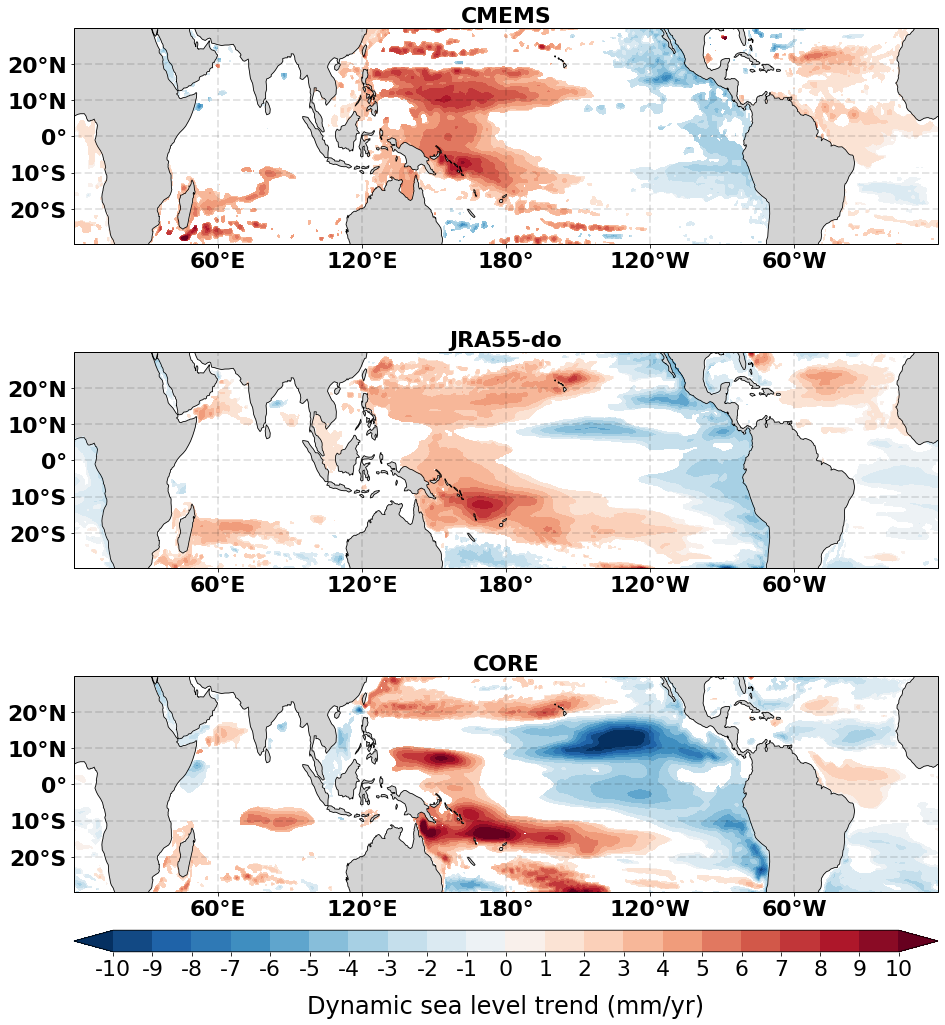

In [37]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.3
level=np.linspace(-0.01, 0.01, 21)

ax2=fig.add_axes([0,0,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))

da_trend = (obs_regrid_regress_mlist['CMEMS']['adt'].slope)\
               .where(np.abs(obs_regrid_regress_mlist['CMEMS']['adt'].slope)\
                            >obs_regrid_regress_mlist['CMEMS']['adt'].conf_int_99,other=np.nan)


im=(da_trend).plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))


# da_conv=(obs_mean_mlist['WESwind']['conv_tx']+obs_mean_mlist['WESwind']['conv_ty'])\
#         .where((da_pacific.lat>0)&
#                (da_pacific.lat<15)&
#                (da_pacific.lon<-110)&
#                (da_pacific.lon>-200),drop=True)

# xy_loc = []
# for nx,x in enumerate(da_conv.x):
#     try:
#         ind = np.argmax(da_conv[:,nx].values)
#         xy_loc.append([x.values,da_conv.y.values[ind]])
#     except ValueError:
#         xy_loc.append([x.values,da_conv.y.values[ind]])

# for loc in xy_loc:
#     ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))

# q=ax2.quiver(obs_regrid_regress_mlist['WESwind']['tx'].lon.values[::30, ::30],
#              obs_regrid_regress_mlist['WESwind']['tx'].lat.values[::30, ::30],
#              obs_regrid_regress_mlist['WESwind']['tx'].slope.values[::30, ::30],
#              obs_regrid_regress_mlist['WESwind']['ty'].slope.values[::30, ::30],
#              scale=5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
#              transform=ccrs.PlateCarree(central_longitude=0))


cb=im.colorbar
cb.remove()
# cbaxes=fig.add_axes([0,0-0.055,0.4,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(abslevel)
# cbar.set_ticklabels(["%0.2f"%(n) for n in abslevel]) #m => mm
# cbar.ax.tick_params(labelsize=22,rotation=45) 
# cbar.set_label(label='SSH (m)',size=24, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('CMEMS', color='black', weight='bold',size=22)
ax2.set_aspect('auto')

#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-devy*(nmodel+1),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())
    
    da_trend = (regrid_regress_mlist[model]['zos'].slope)\
               .where(np.abs(regrid_regress_mlist[model]['zos'].slope)\
                            >regrid_regress_mlist[model]['zos'].conf_int_99,other=np.nan)

    
    im=da_trend.plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
#     q=ax2.quiver(mean_mlist[model]['tauuo'].lon.values[::30, ::30],
#                  mean_mlist[model]['tauuo'].lat.values[::30, ::30],
#                  (mean_mlist[model]['tauuo'].values[::30, ::30]-\
#                  obs_mean_mlist['WESwind']['tx'].values[::30, ::30]),
#                  (mean_mlist[model]['tauvo'].values[::30, ::30]-\
#                  obs_mean_mlist['WESwind']['ty'].values[::30, ::30]),
#                  scale=0.5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
#                  transform=ccrs.PlateCarree(central_longitude=0))
    
#     da_conv=(mean_mlist[model]['conv_tauuo']+mean_mlist[model]['conv_tauvo'])\
#             .where((da_pacific.lat>0)&
#                    (da_pacific.lat<15)&
#                    (da_pacific.lon<-110)&
#                    (da_pacific.lon>-200),drop=True)

#     xy_loc = []
#     for nx,x in enumerate(da_conv.x):
#         try:
#             ind = np.argmax(da_conv[:,nx].values)
#             xy_loc.append([x.values,da_conv.y.values[ind]])
#         except ValueError:
#             xy_loc.append([x.values,da_conv.y.values[ind]])
    
#     for loc in xy_loc:
#         ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))
    
    if nmodel == len(Model_name)-1 :
        cbaxes=fig.add_axes([0,0-devy*(nmodel+1)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=0) 
        cbar.set_label(label='Dynamic sea level trend (mm/yr)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s'%(Model_legend_name[nmodel]), color='black', weight='bold',size=22)
    ax2.set_aspect('auto')

fig.savefig('../figure/figure5.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


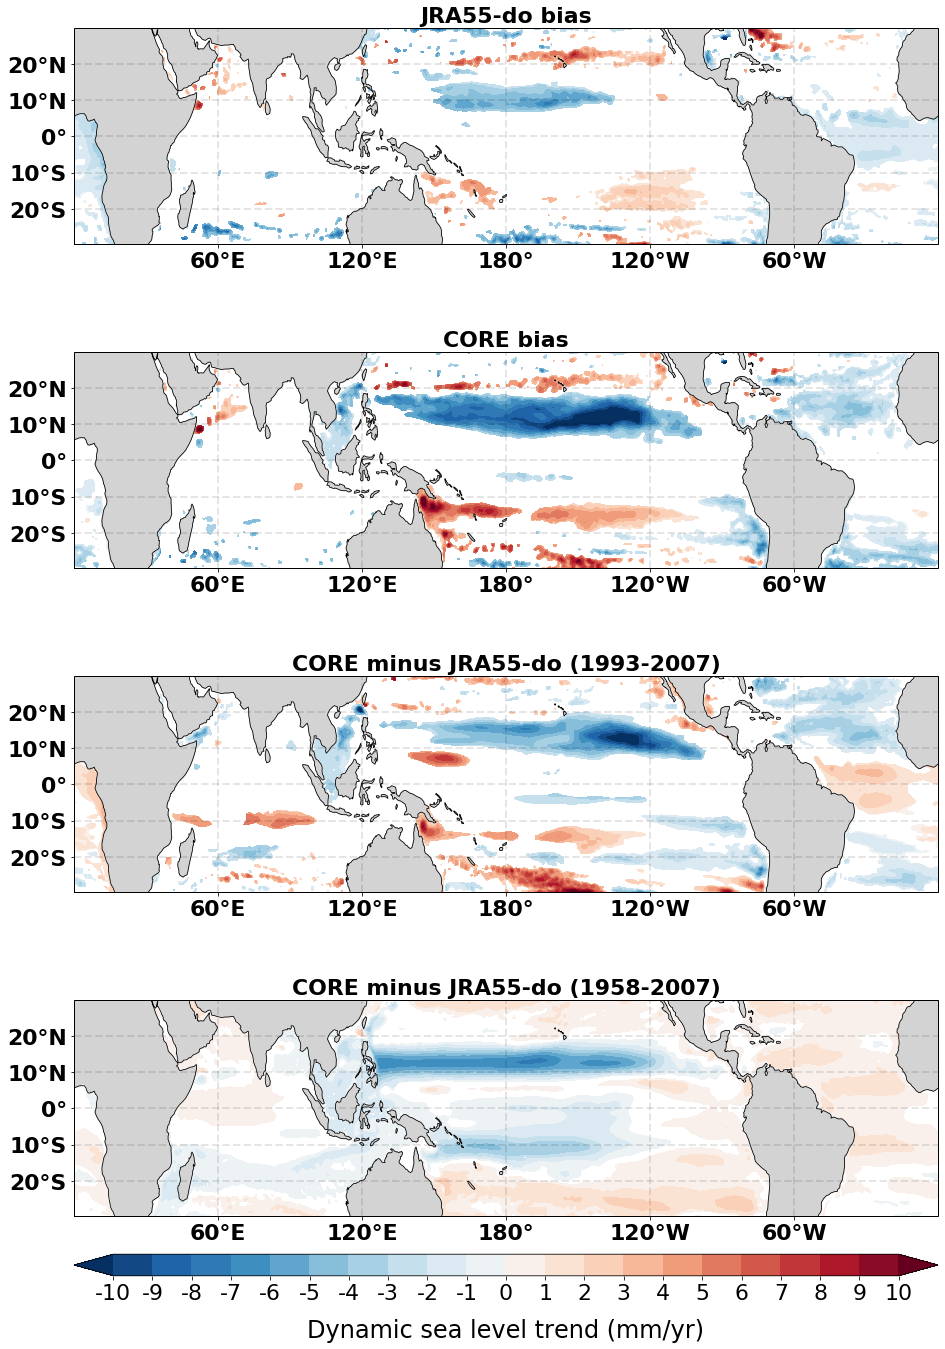

In [38]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.3
level=np.linspace(-0.01, 0.01, 21)


#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-devy*(nmodel),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())

    da_trend_bias = regrid_regress_mlist[model]['zos'].slope\
                    -obs_regrid_regress_mlist['CMEMS']['adt'].slope
    da_trend_bias_conf = np.sqrt(regrid_regress_mlist[model]['zos'].conf_int_99**2\
                                +obs_regrid_regress_mlist['CMEMS']['adt'].conf_int_99**2)
    da_trend_bias = da_trend_bias.where(np.abs(da_trend_bias)>da_trend_bias_conf,other=np.nan)
    
    
    im=da_trend_bias.plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')
    
#########################################################################################
ax2=fig.add_axes([0,0-devy*2,0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
# ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())

da_trend_bias = regrid_regress_mlist['CORE']['zos'].slope\
                -regrid_regress_mlist['JRA']['zos'].slope
da_trend_bias_conf = np.sqrt(regrid_regress_mlist['CORE']['zos'].conf_int_99**2\
                            +regrid_regress_mlist['JRA']['zos'].conf_int_99**2)
da_trend_bias = da_trend_bias.where(np.abs(da_trend_bias)>da_trend_bias_conf,other=np.nan)


im=da_trend_bias.plot.contourf(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('CORE minus JRA55-do (1993-2007)', color='black', weight='bold',size=22)
ax2.set_aspect('auto')


#########################################################################################

ax2=fig.add_axes([0,0-devy*3,0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
# ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())

da_trend_bias = regrid_regress_mlist1['CORE']['zos'].slope\
                -regrid_regress_mlist1['JRA']['zos'].slope
da_trend_bias_conf = np.sqrt(regrid_regress_mlist1['CORE']['zos'].conf_int_99**2\
                            +regrid_regress_mlist1['JRA']['zos'].conf_int_99**2)
da_trend_bias = da_trend_bias.where(np.abs(da_trend_bias)>da_trend_bias_conf,other=np.nan)


im=da_trend_bias.plot.contourf(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()
cbaxes=fig.add_axes([0,0-devy*3-0.055,0.4,0.02])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n*1000) for n in level]) #m => mm
cbar.ax.tick_params(labelsize=22,rotation=0) 
cbar.set_label(label='Dynamic sea level trend (mm/yr)',size=24, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('CORE minus JRA55-do (1958-2007)', color='black', weight='bold',size=22)
ax2.set_aspect('auto')


fig.savefig('../figure/figure6.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


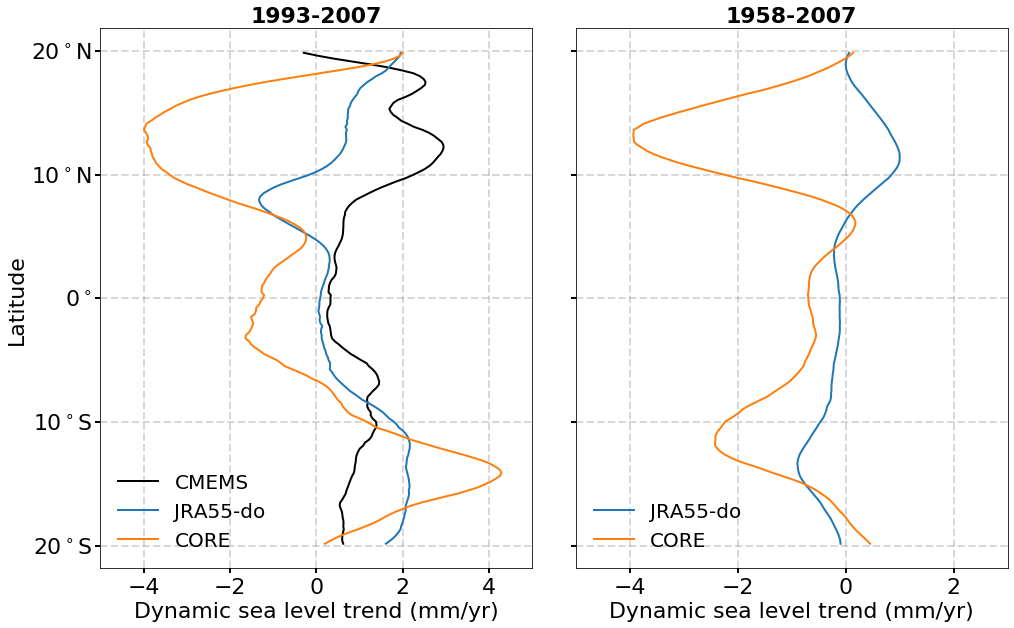

In [45]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.25
level=np.linspace(-0.2, 0.2, 21)


    
#########################################################################################  
ax2=fig.add_axes([0,0,0.2,0.5])

da_obs_trend = (obs_regrid_regress_mlist['CMEMS']['adt'].slope)*1000.

(da_obs_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='CMEMS',
                               color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_trend = (regrid_regress_mlist[model]['zos'].slope)*1000.

    (da_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='%s'%Model_legend_name[nmodel],
                               color=colors[nmodel])


ax2.set_xlim([-5,5])
ax2.set_yticks([-20,-10,0,10,20])
ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('Latitude',size=22)
ax2.set_xlabel('Dynamic sea level trend (mm/yr)',size=22)
ax2.set_title('1993-2007',color='black', weight='bold',size=22)
ax2.legend(loc='lower left',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])


######################################################################################## 
ax2=fig.add_axes([0.22,0,0.2,0.5])
colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_trend = (regrid_regress_mlist1[model]['zos'].slope)*1000.

    (da_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='%s'%Model_legend_name[nmodel],
                               color=colors[nmodel])


ax2.set_xlim([-5,3])
ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.set_yticklabels(['','','','',''], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Dynamic sea level trend (mm/yr)',size=22)
ax2.set_title('1958-2007',color='black', weight='bold',size=22)
ax2.legend(loc='lower left',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])





fig.savefig('../figure/figure7.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


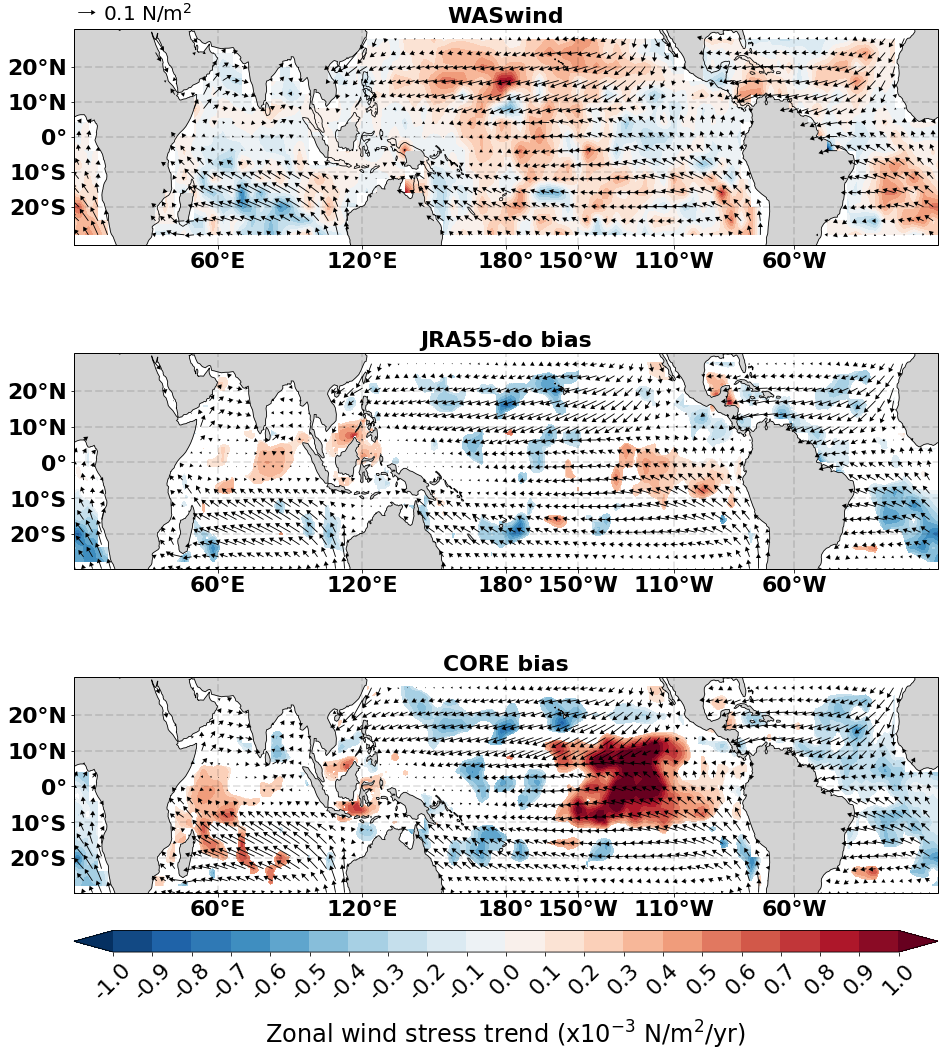

In [65]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.3
level=np.linspace(-1e-3, 1e-3, 21)
# cslevel=np.linspace(-2e-9, 2e-9, 21)



ax2=fig.add_axes([0,0,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))

# da_trend = (obs_regrid_regress_mlist1['WESwind']['tx'].slope)\
#                .where(np.abs(obs_regrid_regress_mlist['WESwind']['tx'].slope)\
#                             >obs_regrid_regress_mlist['WESwind']['tx'].conf_int_99,other=np.nan)

da_trend = (obs_regrid_regress_mlist1['WESwind']['tx'].slope)
# da_trend2 = (obs_regrid_regress_mlist1['WESwind']['curl_tx']+\
#                 obs_regrid_regress_mlist1['WESwind']['curl_ty'])


im=(da_trend).plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))



# cs = (da_trend2).plot.contour(x='lon',
#                                 y='lat',
#                                 ax=ax2, 
#                                 levels=level, 
#                                 colors='k',
#                                 transform=ccrs.PlateCarree(central_longitude=0))


# da_conv=(obs_mean_mlist['WESwind']['conv_tx']+obs_mean_mlist['WESwind']['conv_ty'])\
#         .where((da_pacific.lat>0)&
#                (da_pacific.lat<15)&
#                (da_pacific.lon<-110)&
#                (da_pacific.lon>-200),drop=True)

# xy_loc = []
# for nx,x in enumerate(da_conv.x):
#     try:
#         ind = np.argmax(da_conv[:,nx].values)
#         xy_loc.append([x.values,da_conv.y.values[ind]])
#     except ValueError:
#         xy_loc.append([x.values,da_conv.y.values[ind]])

# for loc in xy_loc:
#     ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))

# q=ax2.quiver(obs_mean_mlist['WESwind']['tx'].lon.values[::25],
#              obs_mean_mlist['WESwind']['tx'].lat.values[::25],
#              obs_mean_mlist['WESwind']['tx'].values[::25, ::25],
#              obs_mean_mlist['WESwind']['ty'].values[::25, ::25],
#              scale=0.02,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
#              transform=ccrs.PlateCarree(central_longitude=0))

q = ax2.quiver(obs_mean_mlist['WESwind']['tx'].lon.values[::1],
             obs_mean_mlist['WESwind']['tx'].lat.values[::1],
             obs_mean_mlist['WESwind']['tx'].values[::1, ::1],
             obs_mean_mlist['WESwind']['ty'].values[::1, ::1],
             scale=5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
             transform=ccrs.PlateCarree(central_longitude=0))

qk = ax2.quiverkey(q, 0.01, 0.215, 0.1, r'0.1 N/m$^2$', labelpos='E',
                   coordinates='figure',fontproperties={'size':20})

cb=im.colorbar
cb.remove()
# cbaxes=fig.add_axes([0,0-0.055,0.4,0.02])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(abslevel)
# cbar.set_ticklabels(["%0.2f"%(n) for n in abslevel]) #m => mm
# cbar.ax.tick_params(labelsize=22,rotation=45) 
# cbar.set_label(label='SSH (m)',size=24, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,210,250,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-150,-110,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('WASwind', color='black', weight='bold',size=22)
ax2.set_aspect('auto')

#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-devy*(nmodel+1),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())

    da_trend_bias = regrid_regress_mlist1[model]['tauuo'].slope\
                    -obs_regrid_regress_mlist1['WESwind']['tx'].slope
    da_trend_bias_conf = np.sqrt(regrid_regress_mlist1[model]['tauuo'].conf_int_99**2\
                                +obs_regrid_regress_mlist1['WESwind']['tx'].conf_int_99**2)
    da_trend_bias = da_trend_bias.where(np.abs(da_trend_bias)>da_trend_bias_conf,other=np.nan)
    
#     da_trend_bias2 = regrid_regress_mlist1[model]['curl_tauuo']\
#                     -obs_regrid_regress_mlist1['WESwind']['curl_tx']
    
    im=da_trend_bias.plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))
    

    
    
#     cs=da_trend_bias.plot.contour(x='lon',
#                                 y='lat',
#                                 ax=ax2, 
#                                 levels=level,  
#                                 colors='k',
#                                 transform=ccrs.PlateCarree(central_longitude=0))

    


    q=ax2.quiver(mean_mlist[model]['tauuo'].lon.values[::15, ::15],
                 mean_mlist[model]['tauuo'].lat.values[::15, ::15],
                 mean_mlist[model]['tauuo'].values[::15, ::15],
                 mean_mlist[model]['tauvo'].values[::15, ::15],
                 scale=5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
                 transform=ccrs.PlateCarree(central_longitude=0))
#     q=ax2.quiver(mean_mlist[model]['tauuo'].lon.values[::25, ::25],
#                  mean_mlist[model]['tauuo'].lat.values[::25, ::25],
#                  mean_mlist[model]['tauuo'].values[::25, ::25],
#                  mean_mlist[model]['tauvo'].values[::25, ::25],
#                  scale=0.02,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
#                  transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
#     da_conv=(mean_mlist[model]['conv_tauuo']+mean_mlist[model]['conv_tauvo'])\
#             .where((da_pacific.lat>0)&
#                    (da_pacific.lat<15)&
#                    (da_pacific.lon<-110)&
#                    (da_pacific.lon>-200),drop=True)

#     xy_loc = []
#     for nx,x in enumerate(da_conv.x):
#         try:
#             ind = np.argmax(da_conv[:,nx].values)
#             xy_loc.append([x.values,da_conv.y.values[ind]])
#         except ValueError:
#             xy_loc.append([x.values,da_conv.y.values[ind]])
    
#     for loc in xy_loc:
#         ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))
    
    if nmodel == len(Model_name)-1 :
        cbaxes=fig.add_axes([0,0-devy*(nmodel+1)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n*1000) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Zonal wind stress trend (x10$^{-3}$ N/m$^2$/yr)',size=24, labelpad=15)
    
    
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,210,250,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-150,-110,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')
    

fig.savefig('../figure/figure8.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


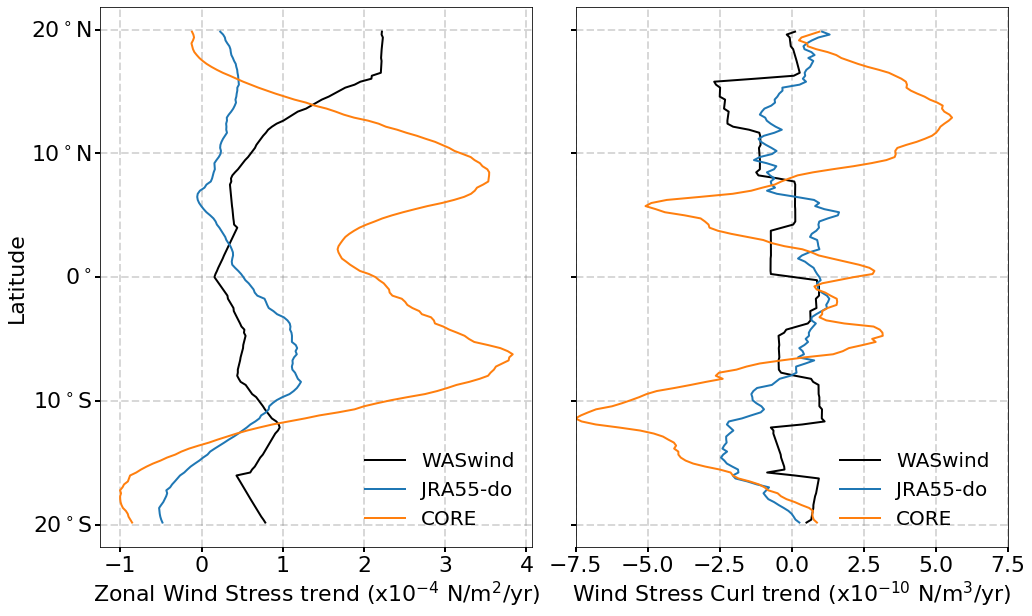

In [46]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.25
level=np.linspace(-0.2, 0.2, 21)


    
#########################################################################################  
ax2=fig.add_axes([0,0,0.2,0.5])

da_obs_trend = obs_regrid_regress_mlist1['WESwind']['tx'].slope*10000.

(da_obs_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='WASwind',
                               color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_trend = regrid_regress_mlist1[model]['tauuo'].slope*10000.

    (da_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='%s'%Model_legend_name[nmodel],
                               color=colors[nmodel])


# ax2.set_xlim([-5,5])
ax2.set_yticks([-20,-10,0,10,20])
ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('Latitude',size=22)
ax2.set_xlabel('Zonal Wind Stress trend (x10$^{-4}$ N/m$^2$/yr)',size=22)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='lower right',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])


######################################################################################## 
ax2=fig.add_axes([0.22,0,0.2,0.5])


da_obs_trend = (obs_regrid_regress_mlist1['WESwind']['curl_tx']+\
                obs_regrid_regress_mlist1['WESwind']['curl_ty'])*1e10

(da_obs_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='WASwind',
                               color='k')


colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_trend = (regrid_regress_mlist1[model]['curl_tauuo']+\
                regrid_regress_mlist1[model]['curl_tauvo'])*1e10

    (da_trend*da_pacific).where((da_pacific.lat>-20)&\
                                (da_pacific.lat<20))\
                         .mean(dim=['x'])\
                         .plot(ax=ax2,
                               y='y',
                               linewidth=2.0,
                               label='%s'%Model_legend_name[nmodel],
                               color=colors[nmodel])


ax2.set_xlim([-7.5,7.5])
ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.set_yticklabels(['','','','',''], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Wind Stress Curl trend (x10$^{-10}$ N/m$^3$/yr)',size=22)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='lower right',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])


fig.savefig('../figure/figure9.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


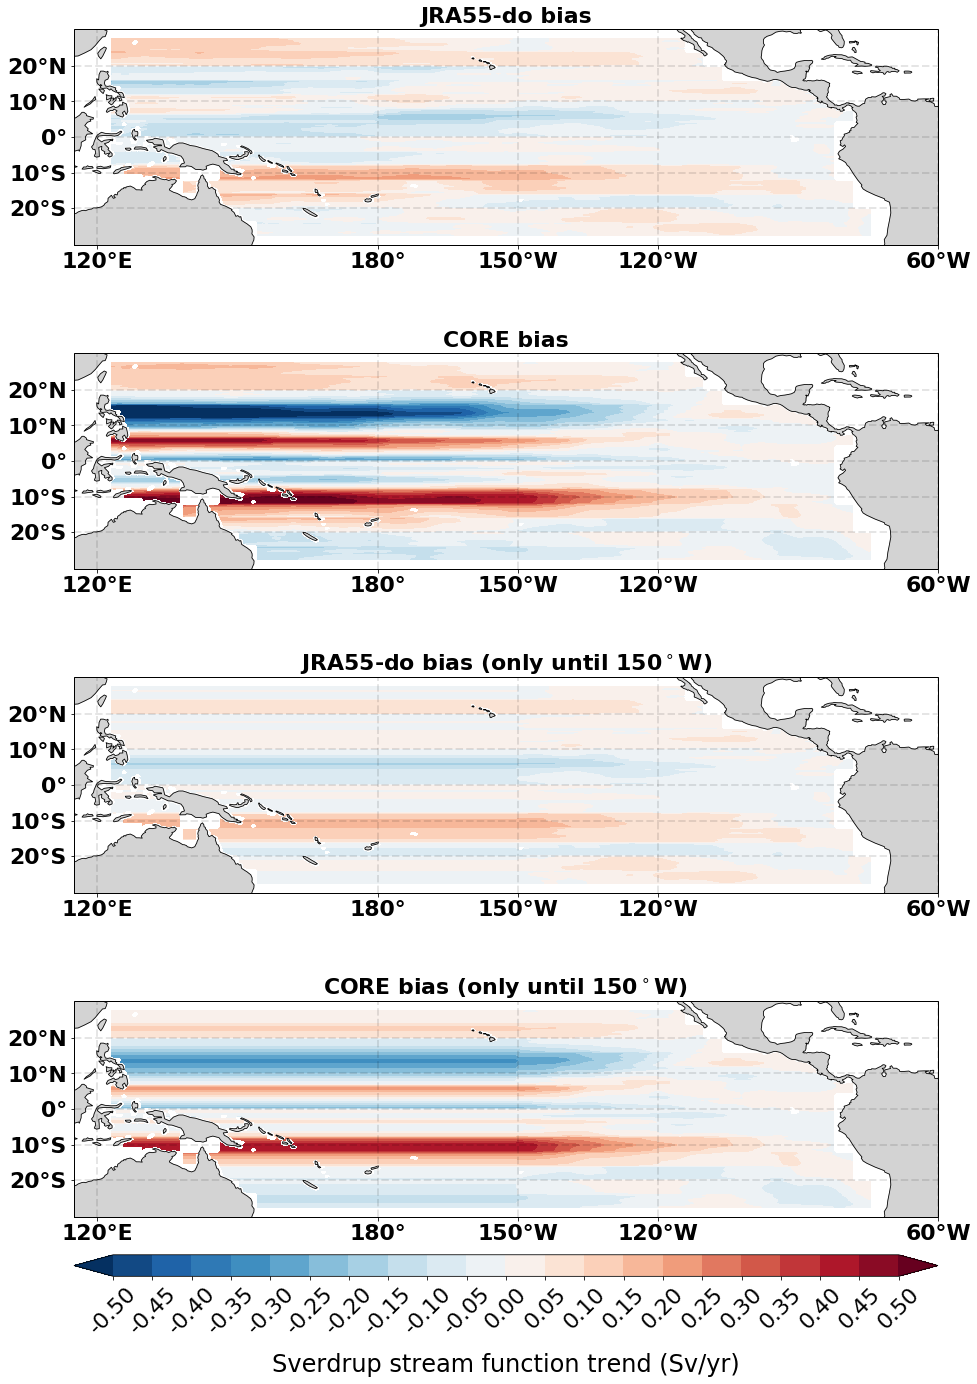

In [68]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(30,15))
devy = 0.3
level = np.linspace(-0.5, 0.5, 21)
var = 'Sv_stream'

da_pacific_str_mask = da_pacific.where(da_pacific.lon>123-360.,other=np.nan)

#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-devy*(nmodel),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    
    da_trend = (regrid_regress_mlist1[model][var]*da_pacific_str_mask)/1e6
    
    da_trend_bias = (regrid_regress_mlist1[model][var]\
                    -obs_regrid_regress_mlist1['WESwind'][var])/1e6*da_pacific_str_mask
    
    
    im=da_trend_bias.plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([120,180,210,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([120,180,-150,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')
    
# #########################################################################################
var = 'Sv_stream_ETP'
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-devy*(nmodel+2),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    
    da_trend = (regrid_regress_mlist1[model][var]*da_pacific_str_mask)/1e6
    
    da_trend_bias = (regrid_regress_mlist1[model][var]\
                    -obs_regrid_regress_mlist1['WESwind'][var])/1e6*da_pacific_str_mask
    
    
    im=da_trend_bias.plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
    if nmodel == len(Model_name)-1 :
        cbaxes=fig.add_axes([0,0-devy*(nmodel+2)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.2f"%(n) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Sverdrup stream function trend (Sv/yr)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([120,180,210,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([120,180,-150,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s bias (only until 150$^\circ$W)'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')





fig.savefig('../figure/figure10.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)
